In [252]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [253]:
df = pd.read_csv("airbnb_data_clean.csv")

# Adding the 'booked' column based on the 'availability_90' column
df['booked'] = df['availability_90'].apply(lambda x: 1 if x < 36 else 0)
df["host_is_superhost"] = df["host_is_superhost"].apply(lambda x: 1 if x == 't' else 0).astype(int)
df["instant_bookable"] = df["instant_bookable"].apply(lambda x: 1 if x == 't' else 0).astype(int)
df['booked'] = df['booked'].astype('category')

In [ ]:
# find unique room types
unique_room_types = df["room_type"].unique()
print(unique_room_types)

['Private room' 'Entire home/apt' 'Shared room']


In [ ]:
# create dummy variable where 1 is the value if an entire home is listed
df["entire_home"] = df["room_type"].apply(lambda x: 1 if x == 'Entire home/apt' else 0).astype(int)

In [ ]:
# find unique bed types
unique_bed_types = df["bed_type"].unique()
print(unique_bed_types)

['Real Bed' 'Futon' 'Pull-out Sofa' 'Couch' 'Airbed']


In [ ]:
# create dummy variable where 1 is the value if it's a real bed. I assume this will be more desirable..!
df["real_bed"] = df["bed_type"].apply(lambda x: 1 if x == 'Real Bed' else 0).astype(int)

In [ ]:
# repeat step for cancellation policy
unique_types = df["cancellation_policy"].unique()
print(unique_types)

['moderate' 'flexible' 'strict' 'super_strict_30' 'no_refunds']


In [ ]:
# create new dummy variable for this
df["cancellation_flexible"] = df["cancellation_policy"].apply(lambda x: 1 if x == 'flexible' else 0).astype(int)

In [ ]:
# Displaying the updated DataFrame, removing non-numeric variables and unnecessary variables
df = df.drop(columns=["room_type",'has_availability','availability_30','availability_60','availability_90',"bed_type",'availability_365','cancellation_policy',"review_scores_accuracy",'neighbourhood','review_scores_cleanliness','property_type','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'], errors="ignore")
print(df.loc[16])

host_is_superhost          1.0
host_listings_count        2.0
accommodates               2.0
bathrooms                  1.0
bedrooms                   1.0
beds                       1.0
price                     85.0
security_deposit         100.0
cleaning_fee              25.0
guests_included            2.0
extra_people              25.0
minimum_nights             2.0
number_of_reviews          9.0
instant_bookable           1.0
booked                     0.0
entire_home                0.0
real_bed                   1.0
cancellation_flexible      0.0
Name: 16, dtype: float64


In [261]:
# split the data into training and testing sets
X = df.drop(['booked'], axis=1)

y = df['booked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

In [262]:
# create an instance of a decision tree classifier using default values
dt = DecisionTreeClassifier(max_depth = None, min_samples_leaf= 75, ccp_alpha = 0)

# fit the model to the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0, min_samples_leaf=75)

In [263]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_default")

'decision_tree_default.pdf'

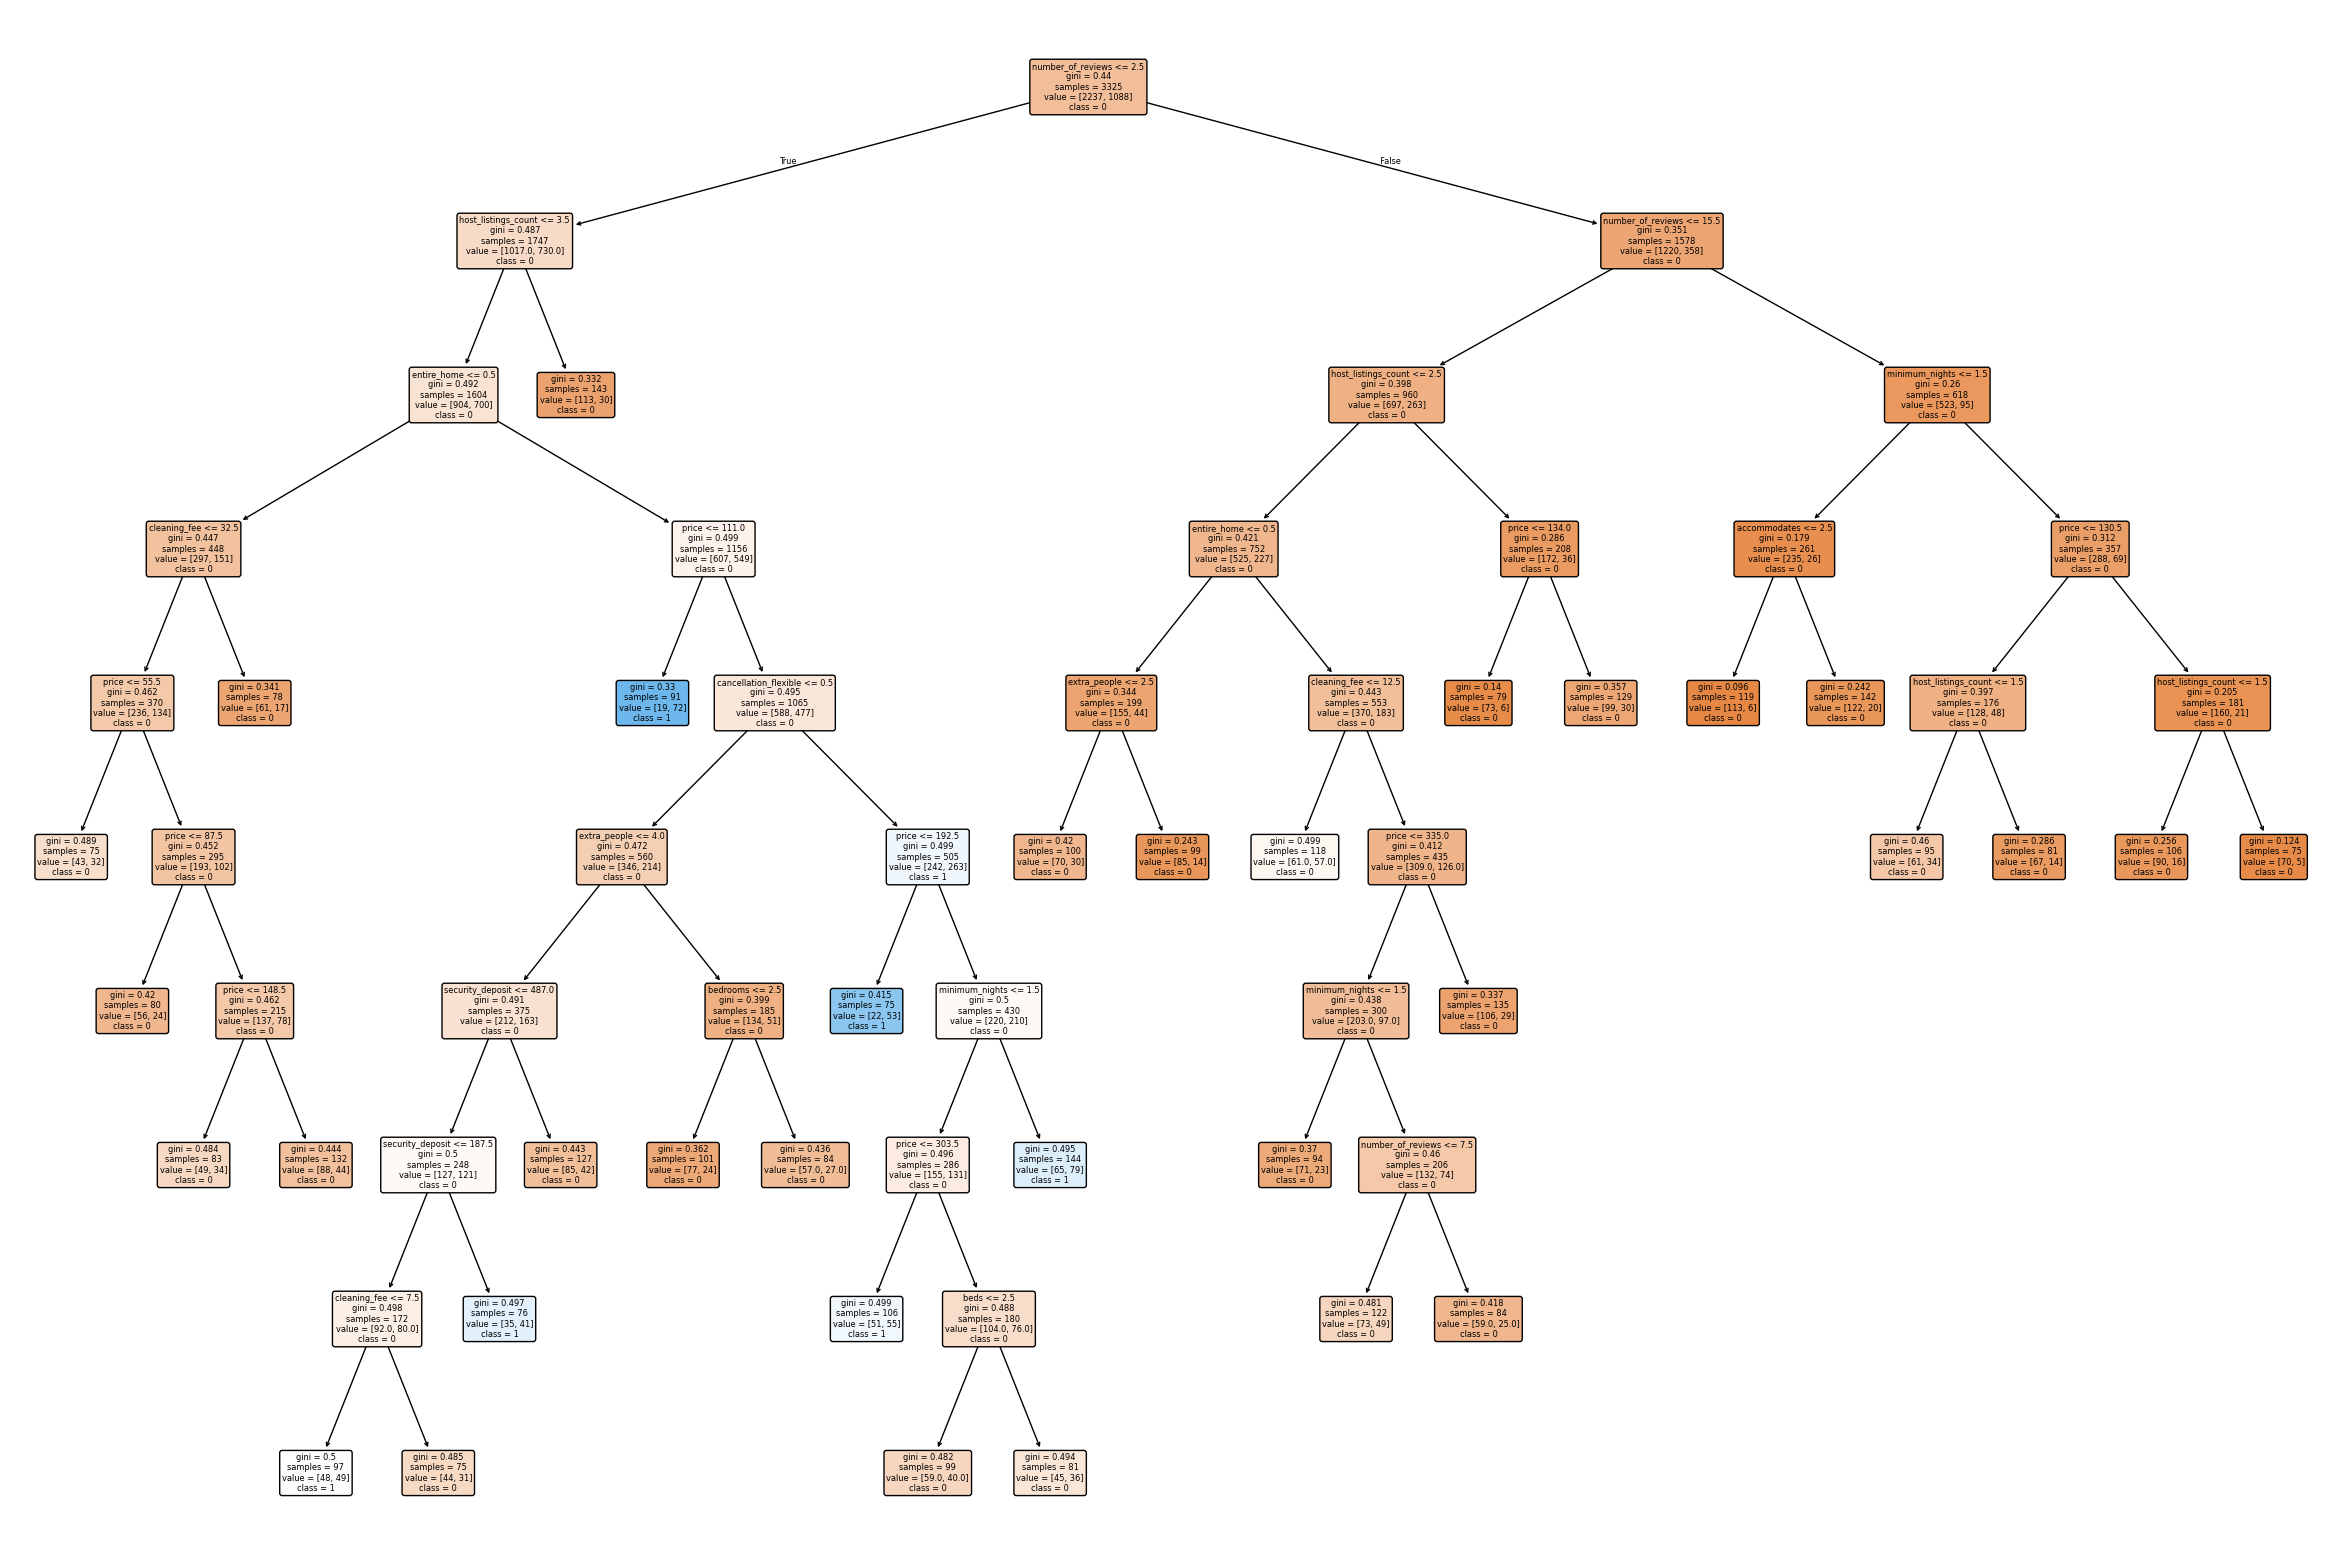

In [264]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from matplotlib import cm

# Plot the decision tree
fig, ax = plt.subplots(figsize=(30, 20))
plot_tree(dt, 
          filled=True, 
          rounded=True, 
          feature_names=X.columns, 
          class_names=['0', '1'], 
          ax=ax)

# Get the collection of patches (nodes) from the plot
for patch in ax.collections:
    # Set the colormap to blue-orange (coolwarm)
    patch.set_facecolor(cm.coolwarm(patch.get_facecolor()[0]))

plt.show()

In [265]:
# make predictions on the training and test data
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

y_prob_train = dt.predict_proba(X_train)
y_prob_test = dt.predict_proba(X_test)

In [266]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.7056
Precision: 0.5925
Recall.  : 0.3208

 -- test set -- 
Accuracy : 0.6985
Precision: 0.5404
Recall.  : 0.2829


In [267]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train, y_train)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test, y_test)
print(conf_matrix)

[[1997  739]
 [ 240  349]]
[[869 322]
 [108 127]]


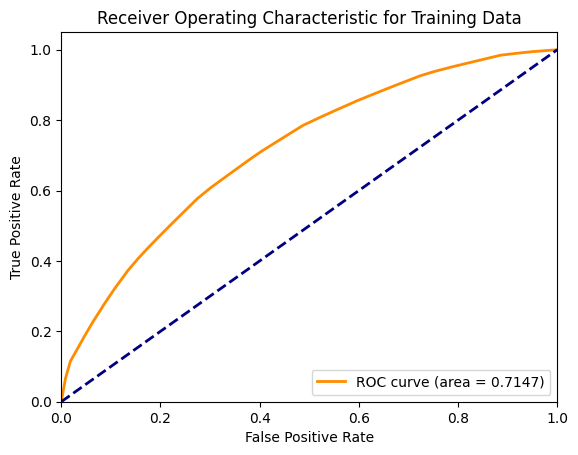

In [268]:
# Generate ROC curve for training data
fpr, tpr, thresholds = roc_curve(y_train.cat.codes, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train.cat.codes, y_prob_train[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

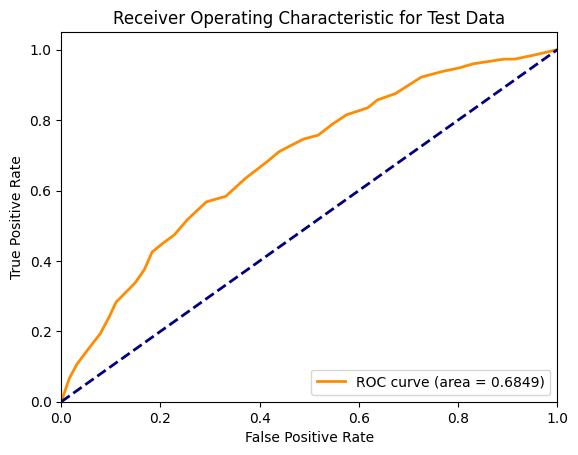

In [269]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test.cat.codes, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test.cat.codes, y_prob_test[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()

    importance                feature
12    0.380312      number_of_reviews
6     0.199050                  price
1     0.118182    host_listings_count
14    0.082970            entire_home
8     0.054270           cleaning_fee
16    0.053604  cancellation_flexible
10    0.046023           extra_people
11    0.031031         minimum_nights
7     0.024854       security_deposit
2     0.005559           accommodates
4     0.003382               bedrooms
5     0.000764                   beds
0     0.000000      host_is_superhost
3     0.000000              bathrooms
9     0.000000        guests_included
13    0.000000       instant_bookable
15    0.000000               real_bed


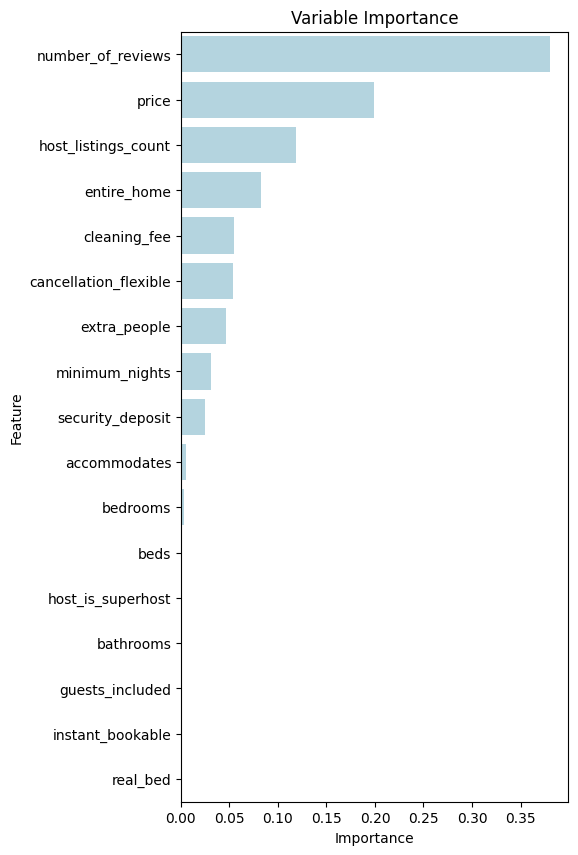

In [270]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()